# Comparison of Searchable Encryption Methods for Vector Search

This notebook compares four different vector search approaches:
1. Simple Non-encrypted Vector Search
2. DCPE (Distance Comparison Preserving Encryption)
3. Paillier Homomorphic Encryption
4. KNN Encryption

We'll measure and compare:
- Setup time
- Document ingestion time
- Search query time
- Result quality

For a fair comparison, we'll use the same document data and search queries for all methods.

## Import Required Libraries

In [1]:
import os
import sys
import time
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import numpy as np
import importlib.util

# Make sure the project directory is in the path
sys.path.append(os.path.abspath('.'))

# Also add DCPE_Method directory to path to fix the DCPE import
dcpe_method_path = os.path.join(os.path.abspath('.'), 'DCPE_Method')
if dcpe_method_path not in sys.path:
    sys.path.append(dcpe_method_path)

# Load environment variables
load_dotenv(override=True)

# Set the document URL for testing
TEST_DOCUMENT_URL = "https://dev.to/kedar_gore_95458be33753b7/rag-vs-fine-tuning-which-approach-is-best-for-enhancing-ai-models-1lfn"
TEST_QUERY = "What is RAG?"

# Utility to measure execution time
def time_function(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    execution_time = end_time - start_time
    return result, execution_time

## Import Methods from All Four Approaches

In [2]:
# Import Simple Non-encrypted Vector Search
print("Importing Simple Vector Search...")
from simple_vector_search import (
    process_and_ingest_data as simple_ingest,
    search_query as simple_search
)

# Import DCPE Method - using direct import instead of relative import
# This is a workaround for the DCPE module not found error
print("Importing DCPE Method...")
try:
    from DCPE_Method.DCPE.rag_encryption_module import RagEncryptionClient
    
    # Now import the encrypted_vector_search functions
    from DCPE_Method.encrypted_vector_search import (
        process_and_ingest_data as dcpe_ingest,
        search_query as dcpe_search,
        rag_client as dcpe_client
    )
    dcpe_available = True
    print("✅ DCPE Method successfully imported")
except ImportError as e:
    print(f"❌ Error importing DCPE Method: {e}")
    dcpe_available = False
    dcpe_ingest = lambda *args: "DCPE not available"
    dcpe_search = lambda *args: "DCPE not available"
    dcpe_client = None

# Import Paillier Method - Properly handle file extension
print("Importing Paillier Method...")
paillier_available = False
paillier_module = None

# Check for both with and without .py extension
paillier_paths = [
    os.path.abspath('Paillier/paillier_encrypted_vector_search.py'),  # With .py extension
    os.path.abspath('Paillier/paillier_encrypted_vector_search')      # Without extension
]

for path in paillier_paths:
    if os.path.exists(path):
        try:
            # Create module name from filename without extension
            module_name = os.path.basename(path).split('.')[0]
            spec = importlib.util.spec_from_file_location(module_name, path)
            if spec and spec.loader:
                paillier_module = importlib.util.module_from_spec(spec)
                spec.loader.exec_module(paillier_module)
                paillier_available = True
                print(f"✅ Paillier Method successfully imported from {path}")
                break
        except Exception as e:
            print(f"❌ Error loading Paillier from {path}: {e}")

if not paillier_available:
    print("❌ Paillier Method could not be imported. File may be missing or invalid.")
    # Create dummy functions for Paillier if not available
    class DummyPaillierModule:
        def process_and_ingest_data(self, *args):
            return "Paillier not available"
        def search_query(self, *args):
            return "Paillier not available"
        public_key = None
        private_key = None
    
    paillier_module = DummyPaillierModule()

# Import KNN Method
print("Importing KNN Method...")
try:
    from KNN.knn_encrypted_vector_search import (
        process_and_ingest_data as knn_ingest,
        search_query as knn_search
    )
    # Also import the KNN encryption functions for key access
    from KNN.knn_encryption import get_or_create_key
    knn_available = True
    print("✅ KNN Method successfully imported")
except ImportError as e:
    print(f"❌ Error importing KNN Method: {e}")
    knn_available = False
    knn_ingest = lambda *args: "KNN not available"
    knn_search = lambda *args: "KNN not available"
    get_or_create_key = lambda: None

Importing Simple Vector Search...


d:\Projects\DCPE - CC (March 2025)\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing DCPE Method...
✅ DCPE Method successfully imported
Importing Paillier Method...
✅ Paillier Method successfully imported from d:\Projects\DCPE - CC (March 2025)\Paillier\paillier_encrypted_vector_search.py
Importing KNN Method...
✅ KNN Method successfully imported


## 1. Measure Setup Time

First, let's measure the time each method takes for initial setup.

In [3]:
# Already initialized as they were imported above
print("All methods have been initialized during import.")

# For comparison purposes, we can measure the time to create encryption keys
setup_times = {
    "Simple (Non-encrypted)": 0  # No encryption setup needed
}

# Measure DCPE key generation time
if dcpe_available and dcpe_client:
    start_time = time.time()
    try:
        # Key is already created during import, but we can note the time to access it
        key_bytes = dcpe_client.vector_encryption_key.get_bytes()
        setup_times["DCPE"] = time.time() - start_time
        print(f"DCPE setup time: {setup_times['DCPE']:.6f} seconds")
    except Exception as e:
        print(f"Error measuring DCPE setup time: {e}")
        setup_times["DCPE"] = None
else:
    setup_times["DCPE"] = None
    print("DCPE not available for setup time measurement")

# Measure Paillier key generation time
if paillier_available:
    start_time = time.time()
    try:
        # Keys were already generated during import
        public_key = paillier_module.public_key
        private_key = paillier_module.private_key
        setup_times["Paillier"] = time.time() - start_time
        print(f"Paillier setup time: {setup_times['Paillier']:.6f} seconds")
    except Exception as e:
        print(f"Error measuring Paillier setup time: {e}")
        setup_times["Paillier"] = None
else:
    setup_times["Paillier"] = None
    print("Paillier not available for setup time measurement")

# Measure KNN encryption setup time
if knn_available:
    start_time = time.time()
    try:
        knn_key = get_or_create_key()
        setup_times["KNN"] = time.time() - start_time
        print(f"KNN setup time: {setup_times['KNN']:.6f} seconds")
    except Exception as e:
        print(f"Error measuring KNN setup time: {e}")
        setup_times["KNN"] = None
else:
    setup_times["KNN"] = None
    print("KNN not available for setup time measurement")

# Display setup times
print("\nSummary of setup times:")
for method, setup_time in setup_times.items():
    if setup_time is not None:
        print(f"{method} setup time: {setup_time:.6f} seconds")
    else:
        print(f"{method} setup time: Not available")

All methods have been initialized during import.
Error measuring DCPE setup time: 'VectorEncryptionKey' object has no attribute 'get_bytes'
Paillier setup time: 0.000002 seconds
KNN setup time: 0.001017 seconds

Summary of setup times:
Simple (Non-encrypted) setup time: 0.000000 seconds
DCPE setup time: Not available
Paillier setup time: 0.000002 seconds
KNN setup time: 0.001017 seconds


## 2. Document Ingestion Performance

Now, let's measure how long it takes each method to process and ingest a document.

In [4]:
# Define a function to safely time ingestion
def safe_ingest_time(ingest_func, *args):
    try:
        start_time = time.time()
        result = ingest_func(*args)
        end_time = time.time()
        return end_time - start_time, True, None
    except Exception as e:
        return -1, False, str(e)

# Measure ingestion times
print("\n📄 Starting document ingestion tests...\n")

# Simple non-encrypted ingestion
print("Simple non-encrypted ingestion:")
simple_time, simple_success, simple_error = safe_ingest_time(simple_ingest, TEST_DOCUMENT_URL)
if simple_success:
    print(f"✅ Completed in {simple_time:.2f} seconds")
else:
    print(f"❌ Failed: {simple_error}")

# DCPE ingestion
print("\nDCPE encrypted ingestion:")
if dcpe_available and dcpe_client:
    dcpe_time, dcpe_success, dcpe_error = safe_ingest_time(dcpe_ingest, TEST_DOCUMENT_URL, dcpe_client)
    if dcpe_success:
        print(f"✅ Completed in {dcpe_time:.2f} seconds")
    else:
        print(f"❌ Failed: {dcpe_error}")
else:
    print("❌ DCPE method not available")
    dcpe_time, dcpe_success = None, False

# Paillier ingestion
print("\nPaillier encrypted ingestion:")
if paillier_available:
    paillier_time, paillier_success, paillier_error = safe_ingest_time(paillier_module.process_and_ingest_data, TEST_DOCUMENT_URL)
    if paillier_success:
        print(f"✅ Completed in {paillier_time:.2f} seconds")
    else:
        print(f"❌ Failed: {paillier_error}")
else:
    print("❌ Paillier method not available")
    paillier_time, paillier_success = None, False

# KNN ingestion
print("\nKNN encrypted ingestion:")
if knn_available:
    knn_time, knn_success, knn_error = safe_ingest_time(knn_ingest, TEST_DOCUMENT_URL)
    if knn_success:
        print(f"✅ Completed in {knn_time:.2f} seconds")
    else:
        print(f"❌ Failed: {knn_error}")
else:
    print("❌ KNN method not available")
    knn_time, knn_success = None, False

# Store times for comparison
ingestion_times = {
    "Simple": simple_time if simple_success else None,
    "DCPE": dcpe_time if dcpe_success else None,
    "Paillier": paillier_time if paillier_success else None,
    "KNN": knn_time if knn_success else None
}


📄 Starting document ingestion tests...

Simple non-encrypted ingestion:
✅ Completed in 14.70 seconds

DCPE encrypted ingestion:
✅ Completed in 14.21 seconds

Paillier encrypted ingestion:
Loaded existing collection: Paillier_Encrypted_Data
Inserted 16 encrypted chunks into the collection
✅ Completed in 119.87 seconds

KNN encrypted ingestion:
✅ Completed in 15.13 seconds


## 3. Search Query Performance

Now, let's measure the search performance of each method using the same query.

In [5]:
# Define a function to safely time search
def safe_search_time(search_func, query, *args):
    try:
        start_time = time.time()
        result = search_func(query, *args)
        end_time = time.time()
        return result, end_time - start_time, True, None
    except Exception as e:
        return None, -1, False, str(e)

# Perform searches
print("\n🔍 Starting search performance tests...\n")

# Simple non-encrypted search
print("Simple non-encrypted search:")
simple_results, simple_search_time, simple_search_success, simple_search_error = safe_search_time(simple_search, TEST_QUERY)
if simple_search_success:
    print(f"✅ Completed in {simple_search_time:.4f} seconds")
else:
    print(f"❌ Failed: {simple_search_error}")

# DCPE search
print("\nDCPE encrypted search:")
if dcpe_available and dcpe_client:
    dcpe_results, dcpe_search_time, dcpe_search_success, dcpe_search_error = safe_search_time(dcpe_search, TEST_QUERY, dcpe_client)
    if dcpe_search_success:
        print(f"✅ Completed in {dcpe_search_time:.4f} seconds")
    else:
        print(f"❌ Failed: {dcpe_search_error}")
else:
    print("❌ DCPE method not available")
    dcpe_results, dcpe_search_time, dcpe_search_success = None, None, False

# Paillier search
print("\nPaillier encrypted search:")
if paillier_available:
    paillier_results, paillier_search_time, paillier_search_success, paillier_search_error = safe_search_time(paillier_module.search_query, TEST_QUERY)
    if paillier_search_success:
        print(f"✅ Completed in {paillier_search_time:.4f} seconds")
    else:
        print(f"❌ Failed: {paillier_search_error}")
else:
    print("❌ Paillier method not available")
    paillier_results, paillier_search_time, paillier_search_success = None, None, False

# KNN search
print("\nKNN encrypted search:")
if knn_available:
    knn_results, knn_search_time, knn_search_success, knn_search_error = safe_search_time(knn_search, TEST_QUERY)
    if knn_search_success:
        print(f"✅ Completed in {knn_search_time:.4f} seconds")
    else:
        print(f"❌ Failed: {knn_search_error}")
else:
    print("❌ KNN method not available")
    knn_results, knn_search_time, knn_search_success = None, None, False

# Store search times for comparison
search_times = {
    "Simple": simple_search_time if simple_search_success else None,
    "DCPE": dcpe_search_time if dcpe_search_success else None,
    "Paillier": paillier_search_time if paillier_search_success else None,
    "KNN": knn_search_time if knn_search_success else None
}


🔍 Starting search performance tests...

Simple non-encrypted search:
✅ Completed in 0.7660 seconds

DCPE encrypted search:
✅ Completed in 0.7125 seconds

Paillier encrypted search:
✅ Completed in 8.2407 seconds

KNN encrypted search:
✅ Completed in 0.7353 seconds


## 4. Visualization and Comparison of Results

Now let's visualize and compare the performance metrics of all methods.

Performance Comparison:


,Method,Setup Time (s),Ingestion Time (s),Search Time (s)
0,Simple,0.000000,14.699822,0.765975
1,DCPE,NaN,14.211271,0.712545
2,Paillier,0.000002,119.874877,8.240664
3,KNN,0.001017,15.133993,0.735271


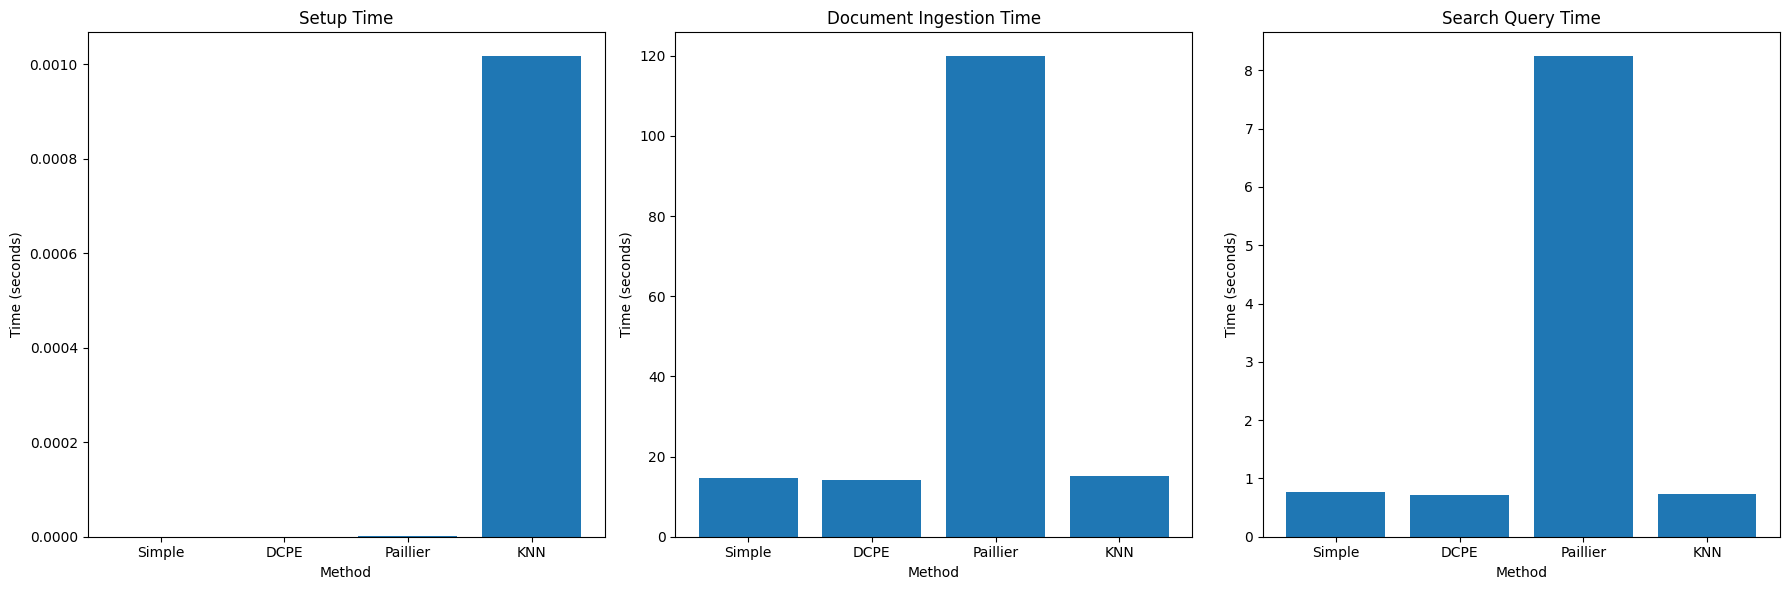

<Figure size 1000x600 with 0 Axes>

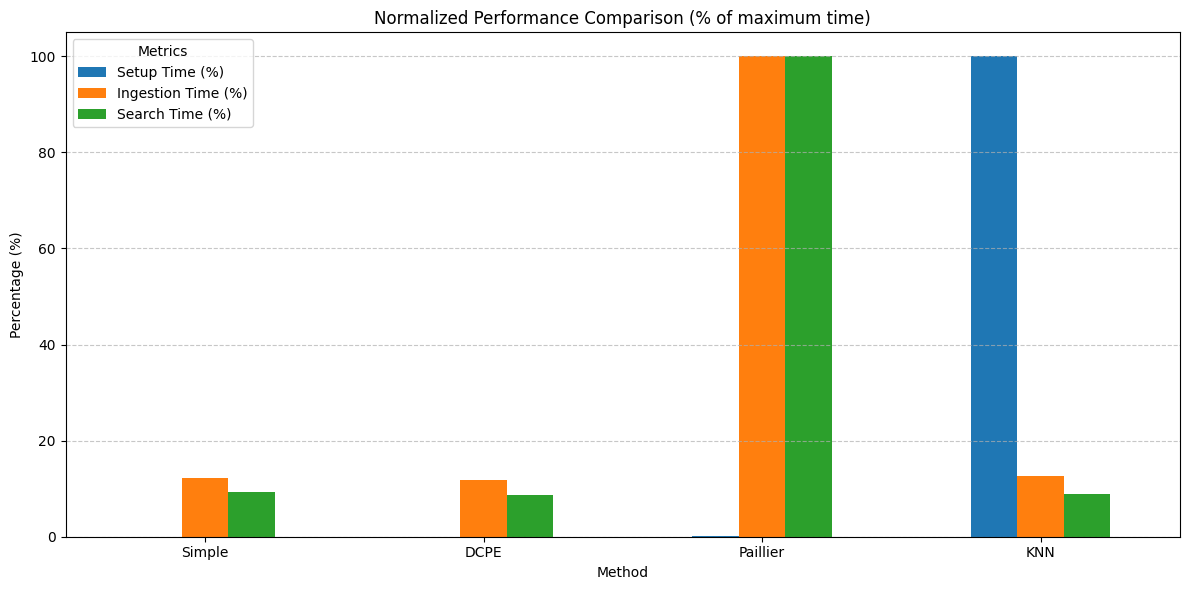

In [6]:
# Create a DataFrame for performance comparison
methods = ["Simple", "DCPE", "Paillier", "KNN"]
performance_data = {
    "Method": methods,
    "Setup Time (s)": [setup_times.get("Simple (Non-encrypted)", None), 
                      setup_times.get("DCPE", None), 
                      setup_times.get("Paillier", None), 
                      setup_times.get("KNN", None)],
    "Ingestion Time (s)": [ingestion_times.get(method, None) for method in methods],
    "Search Time (s)": [search_times.get(method, None) for method in methods]
}

# Convert to DataFrame
performance_df = pd.DataFrame(performance_data)
print("Performance Comparison:")
display(performance_df)

# Get available methods for plotting
available_methods = []
available_setup_times = []
available_ingestion_times = []
available_search_times = []

for i, method in enumerate(methods):
    setup_time = performance_data["Setup Time (s)"][i]
    ingestion_time = performance_data["Ingestion Time (s)"][i]
    search_time = performance_data["Search Time (s)"][i]
    
    # Include methods that have at least one valid metric
    if setup_time is not None or ingestion_time is not None or search_time is not None:
        available_methods.append(method)
        available_setup_times.append(setup_time if setup_time is not None else 0)
        available_ingestion_times.append(ingestion_time if ingestion_time is not None else 0)
        available_search_times.append(search_time if search_time is not None else 0)

# Only create plots if there's data to show
if available_methods:
    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Setup time comparison
    axes[0].bar(available_methods, available_setup_times)
    axes[0].set_title('Setup Time')
    axes[0].set_ylabel('Time (seconds)')
    axes[0].set_xlabel('Method')
    
    # Ingestion time comparison
    axes[1].bar(available_methods, available_ingestion_times)
    axes[1].set_title('Document Ingestion Time')
    axes[1].set_ylabel('Time (seconds)')
    axes[1].set_xlabel('Method')
    
    # Search time comparison
    axes[2].bar(available_methods, available_search_times)
    axes[2].set_title('Search Query Time')
    axes[2].set_ylabel('Time (seconds)')
    axes[2].set_xlabel('Method')
    
    plt.tight_layout()
    plt.show()
    
    # Create a normalized comparison chart
    # This helps visualize relative performance across methods
    def normalize_data(data_list):
        """Normalize data to percentage of maximum value"""
        # Replace None values with 0
        cleaned_data = [0 if x is None else x for x in data_list]
        if max(cleaned_data) == 0:
            return [0] * len(cleaned_data)
        return [x / max(cleaned_data) * 100 for x in cleaned_data]
    
    normalized_performance = {
        "Method": available_methods,
        "Setup Time (%)": normalize_data(available_setup_times),
        "Ingestion Time (%)": normalize_data(available_ingestion_times),
        "Search Time (%)": normalize_data(available_search_times)
    }
    
    # Create normalized chart
    normalized_df = pd.DataFrame(normalized_performance)
    normalized_df = normalized_df.set_index("Method")
    
    # Plot normalized comparative chart
    plt.figure(figsize=(10, 6))
    normalized_df.plot(kind='bar', figsize=(12, 6))
    plt.title("Normalized Performance Comparison (% of maximum time)")
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title="Metrics")
    plt.tight_layout()
    plt.show()
else:
    print("No valid performance data available for plotting.")

## 5. Sample Search Results

Let's look at a sample of the search results from each method to compare quality.

In [7]:
print("\n📋 Sample Search Results\n")

def display_first_result(results, method_name):
    """Display just the first result from each method for comparison"""
    if results and len(results) > 0:
        # Split by 'Result' to get individual results
        result_parts = results.split("Result ")
        if len(result_parts) > 1:
            # Take only the first result and limit length
            first_result = "Result " + result_parts[1]
            # Limit to first 500 chars
            if len(first_result) > 500:
                first_result = first_result[:500] + "..."
            print(f"\n{'-'*80}\n{method_name} - First Result:\n{'-'*80}")
            print(first_result)
        else:
            print(f"\n{method_name} - No valid results found")
    else:
        print(f"\n{method_name} - No results returned")

# Display a sample of results from each method
if simple_search_success:
    display_first_result(simple_results, "Simple Non-encrypted Search")
else:
    print("\nSimple search did not return results")

if dcpe_search_success:
    display_first_result(dcpe_results, "DCPE Encrypted Search")
else:
    print("\nDCPE search did not return results")

if paillier_search_success:
    display_first_result(paillier_results, "Paillier Encrypted Search")
else:
    print("\nPaillier search did not return results")

if knn_search_success:
    display_first_result(knn_results, "KNN Encrypted Search")
else:
    print("\nKNN search did not return results")


📋 Sample Search Results


--------------------------------------------------------------------------------
Simple Non-encrypted Search - First Result:
--------------------------------------------------------------------------------
Result 1 (Similarity Score: 0.34):
------------------------------------------------------------------
Source URL: https://dev.to/apideck/understanding-rag-retrieval-augmented-generation-essentials-for-ai-projects-5dpi
Upload Date: 2025-04-14 21:23:18

Text Content:
Many people often confuse the main concept or philosophy with the tools. RAG becomes synonymous with vector databases, LangChain, embeddings, search engines, data pipelines, and so on. However, this is not the case. As we discussed, R...

--------------------------------------------------------------------------------
DCPE Encrypted Search - First Result:
--------------------------------------------------------------------------------
Result 1 (Similarity Score: 0.43):
---------------------------